## Zoo Animal Classification

> - Zhen Zhao
> - zzhao377@gatech.edu

In [1]:
my_random_seed = 903
my_multiple_jobs = 8

In [2]:
learners_name = []    # collect learner names
learners_metric = []  # collect [accuracy, auc, f1-score]
learners_best = []    # collect best_learners

### Package

In [3]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
%matplotlib inline

In [4]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import *
import itertools
import warnings
warnings.filterwarnings("ignore")

### Import data

In [5]:
# Specify the path
dataset_path = './data'
# features
category_cols = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'tail', 'domestic', 'catsize']
num_cols = ['legs']
label_col = 'class_type'
all_cols = category_cols + num_cols + [label_col]

In [6]:
raw_data = pd.read_csv(os.path.join(dataset_path, 'zoo.csv'), usecols=all_cols)

In [7]:
raw_data.head()

hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  backbone  \
0     1         0     0     1         0        0         1        1         1   
1     1         0     0     1         0        0         0        1         1   
2     0         0     1     0         0        1         1        1         1   
3     1         0     0     1         0        0         1        1         1   
4     1         0     0     1         0        0         1        1         1   

   breathes  venomous  fins  legs  tail  domestic  catsize  class_type  
0         1         0     0     4     0         0        1           1  
1         1         0     0     4     1         0        1           1  
2         0         0     1     0     1         0        0           4  
3         1         0     0     4     0         0        1           1  
4         1         0     0     4     1         0        1           1

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
hair          101 non-null int64
feathers      101 non-null int64
eggs          101 non-null int64
milk          101 non-null int64
airborne      101 non-null int64
aquatic       101 non-null int64
predator      101 non-null int64
toothed       101 non-null int64
backbone      101 non-null int64
breathes      101 non-null int64
venomous      101 non-null int64
fins          101 non-null int64
legs          101 non-null int64
tail          101 non-null int64
domestic      101 non-null int64
catsize       101 non-null int64
class_type    101 non-null int64
dtypes: int64(17)
memory usage: 13.5 KB


In [9]:
raw_data.describe()

hair    feathers        eggs        milk    airborne     aquatic  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.425743    0.198020    0.584158    0.405941    0.237624    0.356436   
std      0.496921    0.400495    0.495325    0.493522    0.427750    0.481335   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      1.000000    0.000000    1.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         predator     toothed    backbone    breathes    venomous        fins  \
count  101.000000  101.000000  101.000000  101.000000  101.000000  101.000000   
mean     0.554455    0.603960    0.821782    0.792079    0.079208    0.168317   
std      0.499505    0.491512    0.384605    0.407844    0.271410    0.376013   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    1.000000    1.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             legs        tail    domestic     catsize  class_type  
count  101.000000  101.000000  101.000000  101.000000  101.000000  
mean     2.841584    0.742574    0.128713    0.435644    2.831683  
std      2.033385    0.439397    0.336552    0.498314    2.102709  
min      0.000000    0.000000    0.000000    0.000000    1.000000  
25%      2.000000    0.000000    0.000000    0.000000    1.000000  
50%      4.000000    1.000000    0.000000    0.000000    2.000000  
75%      4.000000    1.000000    0.000000    1.000000    4.000000  
max      8.000000    1.000000    1.000000    1.000000    7.000000

### Data Preprocessing

In [10]:
# one-hot encoding
encoder = OneHotEncoder(sparse=False)
raw_cat_feat = encoder.fit_transform(raw_data[category_cols].values)

# normalization
scaler = MinMaxScaler()
raw_num_feat = scaler.fit_transform(raw_data[num_cols].values)

# merge features
raw_merge = np.hstack((raw_cat_feat, raw_num_feat))

# use pca
pca = PCA(n_components=0.99)
raw_pca = pca.fit_transform(raw_merge);

In [11]:
raw_data.shape, raw_merge.shape, raw_pca.shape

((101, 17), (101, 31), (101, 13))

In [12]:
# train test split
data_X = raw_pca
data_y = raw_data[label_col]
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=10)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 13), (21, 13), (80,), (21,))

### visualizations

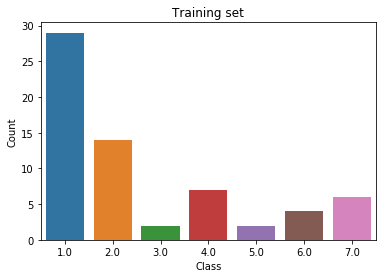

In [14]:
train_data = pd.DataFrame(X_train)
train_data["class_type"] = y_train
sns.countplot(x=label_col, data=train_data)
plt.title('Training set')
plt.xlabel('Class')
plt.ylabel('Count');

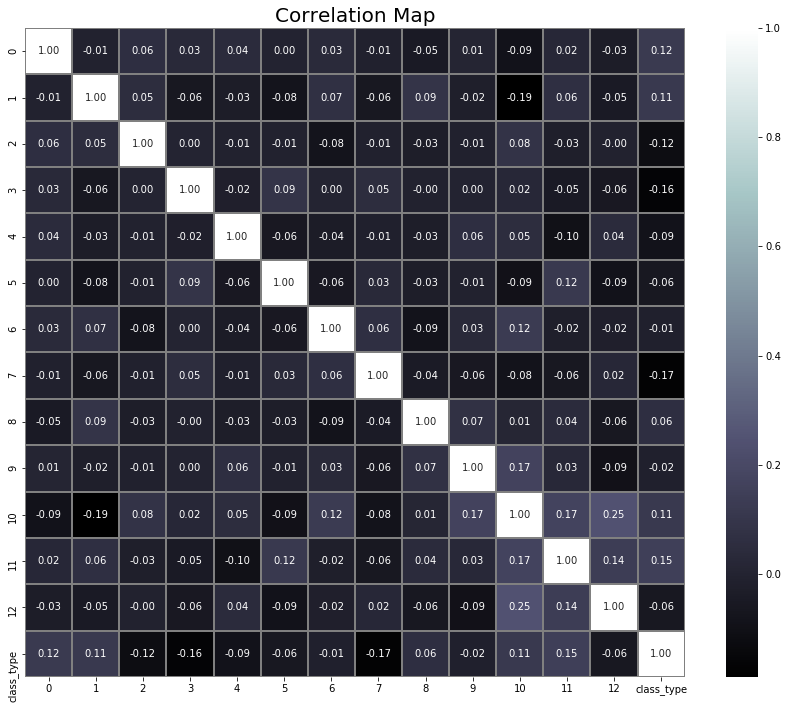

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(data=train_data.corr(),annot=True,cmap="bone",linewidths=1,fmt=".2f",linecolor="gray")
plt.title("Correlation Map",fontsize=20)
plt.tight_layout();  
# lightest and darkest cells are most correlated ones

### Functions

In [16]:
def plot_cm(cm, classes,
            normalize=False,
            title='Confusion matrix',
            cmap=plt.cm.winter,
            colmap=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colmap:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.grid(None)

In [17]:
def get_learn_curve_data(model, X_in=data_X, y_in=data_y, num_cv=10, num_jobs=my_multiple_jobs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, 
                                                            X=X_in, y=y_in, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10), 
                                                            cv=num_cv, 
                                                            n_jobs=num_jobs)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    return [train_sizes, train_mean, train_std, test_mean, test_std]

def draw_learn_curve(res1, y_limit):
    plt.figure(figsize=(10,5))
    plt.plot(res1[0], res1[1], color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(res1[0], res1[1] + res1[2], res1[1] - res1[2], alpha=0.15, color='blue')
    plt.plot(res1[0], res1[3], color='green', linestyle='--', marker='s', markersize=5, label='Testing')
    plt.fill_between(res1[0], res1[3] + res1[4], res1[3] - res1[4], alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim(y_limit)
    plt.grid()

In [18]:
def get_validation_curve_data(model, p_name, p_range, X_in=X_train, y_in=y_train,  
                         num_cv=10, num_jobs=my_multiple_jobs):
    train_scores, test_scores = validation_curve(estimator=model, X=X_in, y=y_in, 
                                             param_name=p_name, param_range=p_range, 
                                             cv=num_cv, n_jobs=num_jobs)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    return [param_range, train_mean, train_std, test_mean, test_std]
    
def draw_validation_curve(res, y_limit):
    plt.figure(figsize=(10,5))
    plt.plot(res[0], res[1], color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(res[0], res[1] + res[2], res[1] - res[2], alpha=0.15, color='blue')
    plt.plot(res[0], res[3], color='green', linestyle='--', marker='s', markersize=5, label='test accuracy')
    plt.fill_between(res[0], res[3] + res[4], res[3] - res[4], alpha=0.15, color='green')
    plt.xscale('log')
    plt.xlabel(para_name)
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim(y_limit)
    plt.grid()

## Learning Algorithms

### KNN

In [19]:
learners_name.append("KNN")

#### Initilization

In [20]:
model = KNeighborsClassifier()
tuned_parameters = {'n_neighbors': [2, 4, 6, 10, 15]}

#### Training and optimizations

In [21]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'n_neighbors': [2, 4, 6, 10, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')


In [22]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [23]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)
metac = accuracy_score(y_test_cmp,y_pred)
metrc = recall_score(y_test_cmp,y_pred, average='macro')
metpr = precision_score(y_test_cmp,y_pred, average='macro')
metf1 = f1_score(y_test_cmp,y_pred, average='macro')

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))

Validating V.S. Testing:
	Validation Accuracy：97.500%
	Testing Accuracy：90.476%
More classification metrics:
	The Running Time is     0.9900s
	The accuracy is         0.9048
	The precision score is  0.7738
	The recall score is     0.8095
	The f1 score is         0.7796


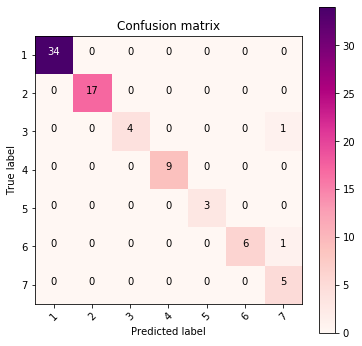

In [24]:
# cm
cm = confusion_matrix(clf.predict(X_train),y_train)
plot_cm(cm,list(range(1,8)), cmap=plt.cm.RdPu, colmap=True)

In [25]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

#### Learning and Validating curve

In [26]:
# learning curve
lc_res = get_learn_curve_data(model)

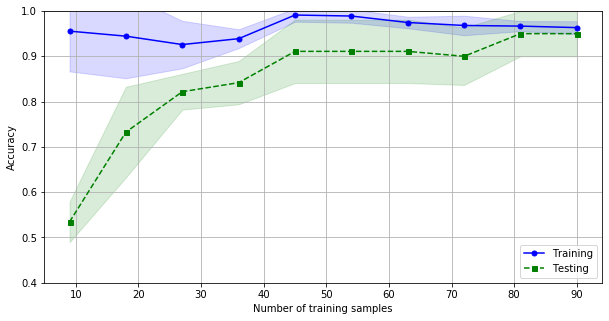

In [27]:
draw_learn_curve(lc_res, [0.4, 1.0])

In [28]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

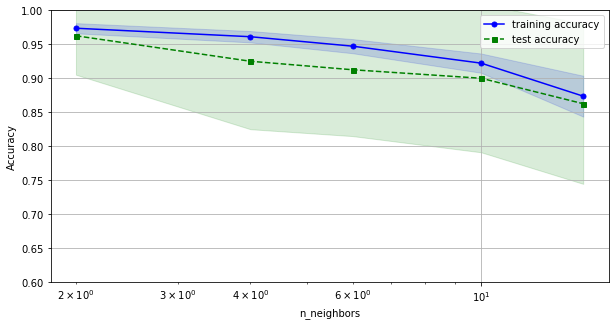

In [29]:
draw_validation_curve(vc_res, [0.6, 1.0]);

### SVM

In [30]:
learners_name.append("SVM")

#### initilization

In [31]:
model = SVC(probability=True, random_state=my_random_seed)
tuned_parameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

#### training and optimizations

In [32]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=903, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=903, shrinking=True, tol=0.001,
    verbose=False)


In [33]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [34]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)
metac = accuracy_score(y_test_cmp,y_pred)
metrc = recall_score(y_test_cmp,y_pred, average='macro')
metpr = precision_score(y_test_cmp,y_pred, average='macro')
metf1 = f1_score(y_test_cmp,y_pred, average='macro')

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))

Validating V.S. Testing:
	Validation Accuracy：98.750%
	Testing Accuracy：90.476%
More classification metrics:
	The Running Time is     0.1069s
	The accuracy is         0.9048
	The precision score is  0.7738
	The recall score is     0.8095
	The f1 score is         0.7796


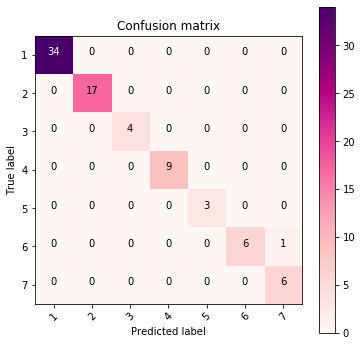

In [35]:
# cm
cm = confusion_matrix(clf.predict(X_train),y_train)
plot_cm(cm,list(range(1,8)), cmap=plt.cm.RdPu, colmap=True)

In [36]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

#### Learning and Validating curve

In [37]:
model1 = SVC(probability=True, random_state=my_random_seed, kernel='linear')
model2 = SVC(probability=True, random_state=my_random_seed, kernel='rbf')

In [38]:
res1 = get_learn_curve_data(model1)
res2 = get_learn_curve_data(model2)

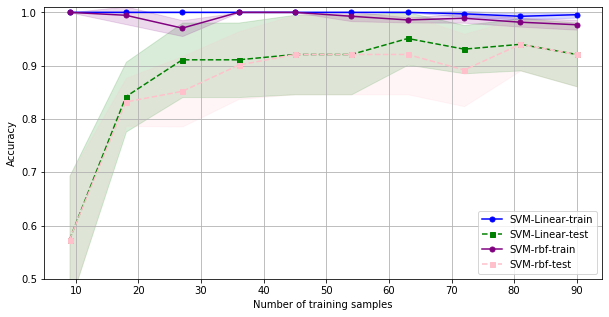

In [39]:
plt.figure(figsize=(10,5))

# model 1
plt.plot(res1[0], res1[1], color='blue', marker='o', markersize=5, label='SVM-Linear-train')
plt.fill_between(res1[0], res1[1] + res1[2], res1[1] - res1[2], alpha=0.15, color='blue')
plt.plot(res1[0], res1[3], color='green', linestyle='--', marker='s', markersize=5, label='SVM-Linear-test')
plt.fill_between(res1[0], res1[3] + res1[4], res1[3] - res1[4], alpha=0.15, color='green')

# model2
plt.plot(res2[0], res2[1], color='purple', marker='o', markersize=5, label='SVM-rbf-train')
plt.fill_between(res2[0], res2[1] + res2[2], res2[1] - res2[2], alpha=0.15, color='purple')
plt.plot(res2[0], res2[3], color='pink', linestyle='--', marker='s', markersize=5, label='SVM-rbf-test')
plt.fill_between(res2[0], res2[3] + res2[4], res2[3] - res2[4], alpha=0.15, color='pink')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.01])
plt.grid();

In [40]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model2, para_name, param_range)

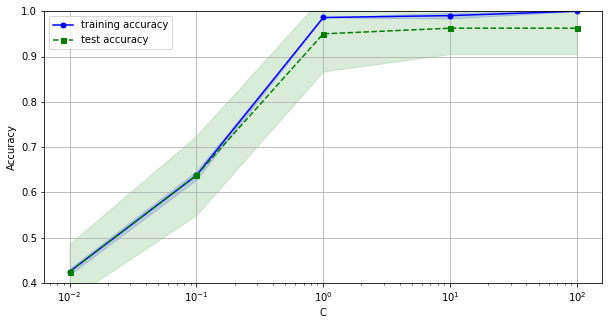

In [41]:
draw_validation_curve(vc_res,[0.4, 1.0])

### Decision Tree

In [42]:
learners_name.append("DTree")

#### initilization

In [43]:
model = DecisionTreeClassifier(criterion='gini', 
                               min_samples_leaf =5, 
                               min_samples_split=5, 
                               random_state=my_random_seed)
tuned_parameters = {'max_depth': [10, 15, 20, 25, 30]}

#### Training and optimizations

In [44]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=5,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=903,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'max_depth': [10, 15, 20, 25, 30]},
             pre_disp

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=903, splitter='best')


In [45]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [46]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)
metac = accuracy_score(y_test_cmp,y_pred)
metrc = recall_score(y_test_cmp,y_pred, average='macro')
metpr = precision_score(y_test_cmp,y_pred, average='macro')
metf1 = f1_score(y_test_cmp,y_pred, average='macro')

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))

Validating V.S. Testing:
	Validation Accuracy：96.250%
	Testing Accuracy：85.714%
More classification metrics:
	The Running Time is     0.0815s
	The accuracy is         0.8571
	The precision score is  0.6286
	The recall score is     0.6429
	The f1 score is         0.6151


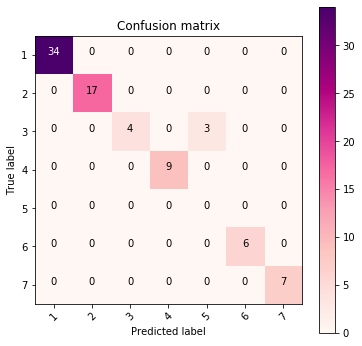

In [47]:
# cm
cm = confusion_matrix(clf.predict(X_train),y_train)
plot_cm(cm,list(range(1,8)), cmap=plt.cm.RdPu, colmap=True)

In [48]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

#### Learning and Validating curve

In [49]:
# learning curve
lc_res = get_learn_curve_data(model)

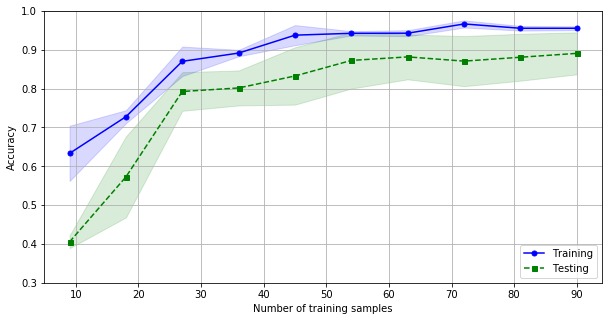

In [50]:
draw_learn_curve(lc_res, [0.3, 1.0])

In [51]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

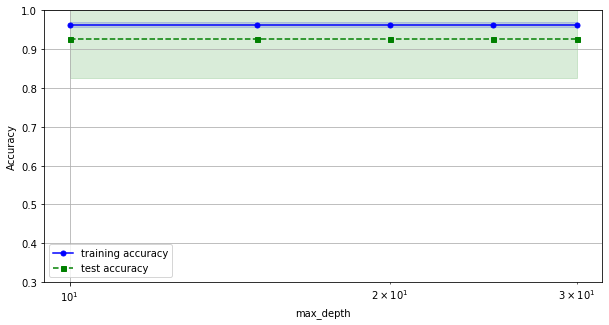

In [52]:
draw_validation_curve(vc_res, [0.3, 1.0]);

### GBDT

In [53]:
learners_name.append("GBDT")

#### initilization

In [54]:
model = GradientBoostingClassifier(min_samples_leaf=10, 
                                   subsample=0.8, 
                                   random_state=my_random_seed, 
                                   learning_rate =0.1)
tuned_parameters = {'max_depth': [10, 15, 20, 25, 30], 'min_samples_split': [10, 15, 20, 25, 30]}

#### Training and optimizations

In [55]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=10,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=903, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [56]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [57]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)
metac = accuracy_score(y_test_cmp,y_pred)
metrc = recall_score(y_test_cmp,y_pred, average='macro')
metpr = precision_score(y_test_cmp,y_pred, average='macro')
metf1 = f1_score(y_test_cmp,y_pred, average='macro')

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))

Validating V.S. Testing:
	Validation Accuracy：100.000%
	Testing Accuracy：90.476%
More classification metrics:
	The Running Time is     6.6910s
	The accuracy is         0.9048
	The precision score is  0.7929
	The recall score is     0.7857
	The f1 score is         0.7732


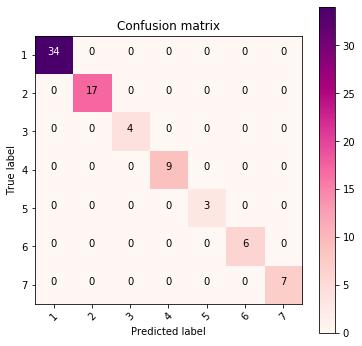

In [58]:
# cm
cm = confusion_matrix(clf.predict(X_train),y_train)
plot_cm(cm,list(range(1,8)), cmap=plt.cm.RdPu, colmap=True)

In [59]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

#### Learning and Validating curve

In [60]:
# learning curve
lc_res = get_learn_curve_data(model)

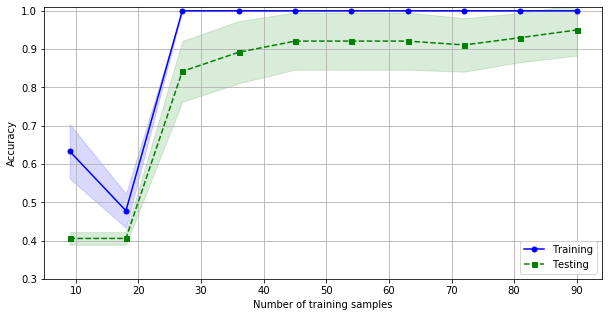

In [61]:
draw_learn_curve(lc_res, [0.3, 1.01])

In [62]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

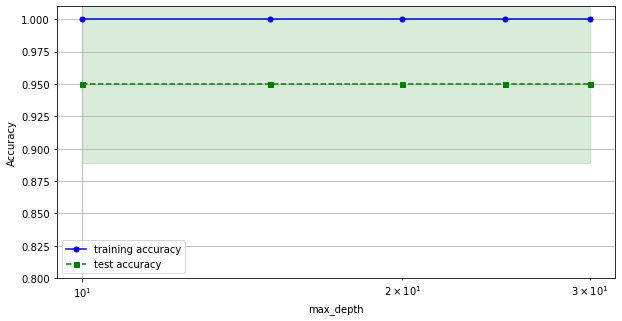

In [63]:
draw_validation_curve(vc_res, [0.8, 1.01]);

### NN

In [64]:
learners_name.append("MLP")

#### initilization

In [65]:
# model = MLPClassifier(activation='relu', solver='sgd', 
#                       learning_rate_init=.01, 
#                       hidden_layer_sizes=(10, 5, 3), 
#                       max_iter=200, 
#                       random_state=my_random_seed, 
#                       warm_start=True)
# tuned_parameters = {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}

In [66]:
model = MLPClassifier(activation='relu', solver='sgd', 
                      learning_rate_init=.01, 
                      hidden_layer_sizes=(10, 10, 10), 
                      random_state=my_random_seed, 
                      warm_start=True)
tuned_parameters = {"max_iter": [50, 100, 150, 200, 300], 'alpha': [1e-2, 1e-3, 1e-4, 1e-5]}

#### Training and optimizations

In [67]:
clf = GridSearchCV(estimator=model,
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='accuracy',
                   refit=True, 
                   n_jobs=my_multiple_jobs);
start = time.time()
clf.fit(X_train, y_train)
print(clf.best_estimator_)

# timing
end = time.time()
duration = end - start

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08,
                                     hidden_layer_sizes=(10, 10, 10),
                                     learning_rate='constant',
                                     learning_rate_init=0.01, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=903, shuffle=True,
                                     solver='sgd', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=True),
             iid='deprecated'

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=903, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=True)


In [68]:
learners_best.append(clf.best_estimator_)

#### Performance analysis

In [69]:
print("Validating V.S. Testing:")
# verification
train_score = clf.score(X_train, y_train)
print('\tValidation Accuracy：{:.3f}%'.format(train_score * 100))

# test
test_score = clf.score(X_test, y_test)
print('\tTesting Accuracy：{:.3f}%'.format(test_score * 100))

print("More classification metrics:")
y_pred = clf.predict(X_test)
y_test_cmp = np.array(y_test)
metac = accuracy_score(y_test_cmp,y_pred)
metrc = recall_score(y_test_cmp,y_pred, average='macro')
metpr = precision_score(y_test_cmp,y_pred, average='macro')
metf1 = f1_score(y_test_cmp,y_pred, average='macro')

print("\tThe Running Time is     {:.4f}s".format(duration))
print("\tThe accuracy is         {0:0.4f}".format(np.mean(metac)))
print("\tThe precision score is  {0:0.4f}".format(np.mean(metpr)))
print("\tThe recall score is     {0:0.4f}".format(np.mean(metrc)))
print("\tThe f1 score is         {0:0.4f}".format(np.mean(metf1)))

Validating V.S. Testing:
	Validation Accuracy：97.500%
	Testing Accuracy：90.476%
More classification metrics:
	The Running Time is     2.1766s
	The accuracy is         0.9048
	The precision score is  0.7738
	The recall score is     0.8095
	The f1 score is         0.7796


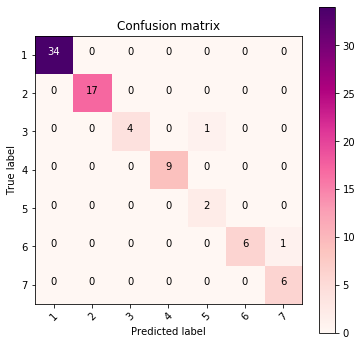

In [70]:
# cm
cm = confusion_matrix(clf.predict(X_train),y_train)
plot_cm(cm,list(range(1,8)), cmap=plt.cm.RdPu, colmap=True)

In [71]:
learners_metric.append([train_score, test_score, duration, np.mean(metf1), np.mean(metpr), np.mean(metrc)])

#### Learning and Validating curve

In [72]:
# learnging curve
from tensorflow import keras
from tensorflow.keras import utils, preprocessing
from tensorflow.keras import layers, models

y_cat_test = utils.to_categorical(y_test)
y_cat_train = utils.to_categorical(y_train)



nn_model = models.Sequential()
nn_model.add(layers.Dense(10, input_shape=(13,), activation='relu'))
nn_model.add(layers.Dense(10, activation='relu'))
nn_model.add(layers.Dense(10, activation='relu'))
nn_model.add(layers.Dense(8, activation='softmax'))

nn_model.summary()

nn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [73]:
hist2 = nn_model.fit(X_train, y_cat_train, 
                  epochs=100, 
                  validation_data=(X_test, y_cat_test), 
                  use_multiprocessing=True)

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 1s 12ms/sample - loss: 2.0643 - acc: 0.0250 - val_loss: 2.0746 - val_acc: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 0s 702us/sample - loss: 2.0446 - acc: 0.0375 - val_loss: 2.0638 - val_acc: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 0s 639us/sample - loss: 2.0265 - acc: 0.0375 - val_loss: 2.0533 - val_acc: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 0s 613us/sample - loss: 2.0085 - acc: 0.0375 - val_loss: 2.0427 - val_acc: 0.0000e+00
Epoch 5/100
80/80 [==============================] - 0s 658us/sample - loss: 1.9910 - acc: 0.0500 - val_loss: 2.0330 - val_acc: 0.0476
Epoch 6/100
80/80 [==============================] - 0s 561us/sample - loss: 1.9728 - acc: 0.0625 - val_loss: 2.0235 - val_acc: 0.0952
Epoch 7/100
80/80 [==============================] - 0s 504us/sample - loss: 1.9552 - acc: 0.1750 - val_loss: 2.0140 - val_acc: 0.0

Epoch 61/100
80/80 [==============================] - 0s 506us/sample - loss: 0.8820 - acc: 0.7250 - val_loss: 1.1680 - val_acc: 0.6667
Epoch 62/100
80/80 [==============================] - 0s 523us/sample - loss: 0.8676 - acc: 0.7250 - val_loss: 1.1549 - val_acc: 0.6667
Epoch 63/100
80/80 [==============================] - 0s 500us/sample - loss: 0.8536 - acc: 0.7250 - val_loss: 1.1419 - val_acc: 0.6667
Epoch 64/100
80/80 [==============================] - 0s 487us/sample - loss: 0.8393 - acc: 0.7250 - val_loss: 1.1293 - val_acc: 0.6667
Epoch 65/100
80/80 [==============================] - 0s 541us/sample - loss: 0.8267 - acc: 0.7375 - val_loss: 1.1170 - val_acc: 0.6667
Epoch 66/100
80/80 [==============================] - 0s 508us/sample - loss: 0.8117 - acc: 0.7375 - val_loss: 1.1053 - val_acc: 0.6667
Epoch 67/100
80/80 [==============================] - 0s 568us/sample - loss: 0.7993 - acc: 0.7375 - val_loss: 1.0941 - val_acc: 0.6667
Epoch 68/100
80/80 [============================

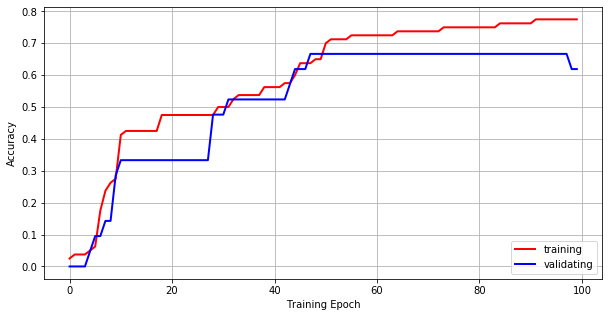

In [74]:
# hist2.history.keys()
plt.figure(figsize=(10,5))
plt.plot(hist2.epoch, hist2.history.get('acc'), c='r', label="training", linewidth=2)
plt.plot(hist2.epoch, hist2.history.get('val_acc'), c='b', label="validating",  linewidth=2)
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid();

In [75]:
# validation curve
para_name = list(tuned_parameters.keys())[0]
param_range = list(tuned_parameters.values())[0]
vc_res = get_validation_curve_data(model, para_name, param_range)

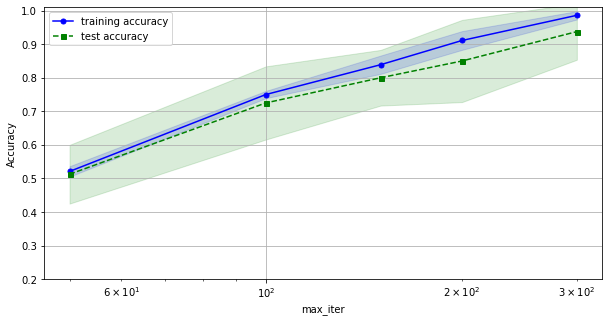

In [76]:
draw_validation_curve(vc_res, [0.2, 1.01]);

## Overall Comparison for  best learners

In [77]:
learners_name

['KNN', 'SVM', 'DTree', 'GBDT', 'MLP']

### Metrics Comparison

In [78]:
if len(learners_metric) == 5 and len(learners_name) == 5:
    metrics_name = ["Validate_acc", "Test_acc", "Run-time", "F1-score", "Precision", "Recall"]
    df_metric = pd.DataFrame(learners_metric, columns=metrics_name)
    df_metric['learners'] = learners_name
    df_metric

Validate_acc  Test_acc  Run-time  F1-score  Precision    Recall learners
0        0.9750  0.904762  0.990035  0.779592   0.773810  0.809524      KNN
1        0.9875  0.904762  0.106937  0.779592   0.773810  0.809524      SVM
2        0.9625  0.857143  0.081484  0.615079   0.628571  0.642857    DTree
3        1.0000  0.904762  6.690996  0.773243   0.792857  0.785714     GBDT
4        0.9750  0.904762  2.176563  0.779592   0.773810  0.809524      MLP

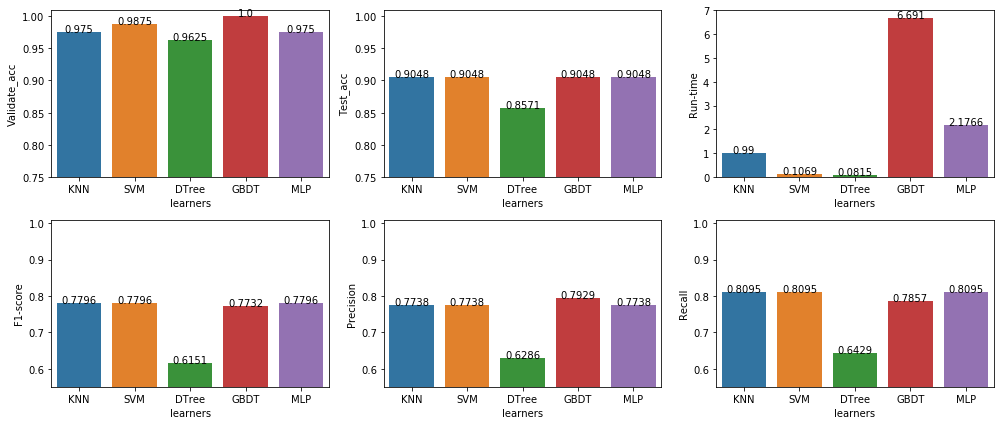

In [80]:
plt.figure(figsize=(14, 6))
for i in range(len(metrics_name)):
    plt.subplot(2,3,i+1)
    y_name = metrics_name[i]
    g = sns.barplot(data=df_metric, x="learners", y=y_name)
    for index, row in df_metric.iterrows():
        g.text(row.name,row[y_name],round(row[y_name],4),color="black",ha="center");
    if i <2:
        plt.ylim([0.75, 1.01])
    elif i > 2:
        plt.ylim([0.55, 1.01])
plt.tight_layout();